In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sn
import pandas as pd
import numpy as np
import random
import cv2
import os

In [2]:
model_20221030 = load_model('../Trained_models/20221030_atherosclerosis_model.h5')
model_20221031 = load_model('../Trained_models/20221031_atherosclerosis_model.h5')
model_20230325 = load_model('../Trained_models/20230325_atherosceloris_model.h5')
model_20230326 = load_model('../Trained_models/20230326_atherosceloris_model.h5')
model_20230329 = load_model('../Trained_models/20230329_atherosceloris_model.h5')
model_20230330 = load_model('../Trained_models/20230330_atherosceloris_model.h5')
model_20230331 = load_model('../Trained_models/20230331_atherosceloris_model.h5')
model_20230421 = load_model('../Trained_models/20230421_atherosceloris_model.h5')
model_20230422 = load_model('../Trained_models/20230422_atherosceloris_model.h5')
model_20230423 = load_model('../Trained_models/20230423_atherosceloris_model.h5')
model_20230501 = load_model('../Trained_models/20230501_atherosceloris_model.h5')
model_20230505 = load_model('../Trained_models/20230505_atherosceloris_model.h5')

In [3]:
SIZE_X = 544
SIZE_Y = 544
n_classes = 4

In [4]:
input_dir = "../Dataset/images/"
mask_dir = "../Dataset/labels/"

train_images = []
for directory_path in glob(input_dir):
    for img_path in glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        train_images.append(img)
        
train_images = np.array(train_images)

train_masks = []
for directory_path in glob(mask_dir):
    for mask_path in glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        train_masks.append(mask)

train_masks = np.array(train_masks)

In [5]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks, axis=3)

X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state=42)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print("Class values in the dataset are ...", np.unique(y_train))

Class values in the dataset are ... [0 1 2 3]


In [6]:
y_pred = model_20221030.predict(X_test)

2023-05-12 11:23:16.932625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-12 11:23:16.935130: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
predictions = np.argmax(y_pred, axis=3)

In [8]:
y_test = np.squeeze(y_test, axis=(3,))

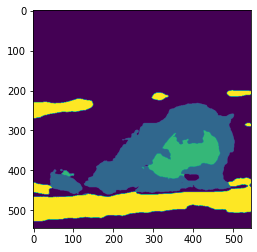

In [9]:
plt.imshow(predictions[0])

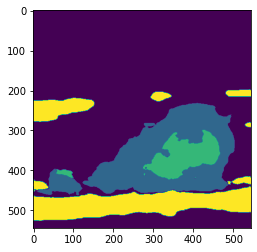

In [10]:
plt.imshow(y_test[0])

In [11]:
cf_matrix = multilabel_confusion_matrix(y_test[0], predictions[0])

NameError: name 'multilabel_confusion_matrix' is not defined

In [58]:
metrics.accuracy_score(y_test.reshape(-1), predictions.reshape(-1))

0.9740388105039176

In [12]:
np.unique(predictions)

array([0, 1, 2, 3])

In [13]:
num_classes = 4
IOU = MeanIoU(num_classes=num_classes, dtype=int)
IOU.update_state(y_test, predictions)

<tf.Variable 'UnreadVariable' shape=(4, 4) dtype=float32, numpy=
array([[1.6777216e+07, 6.0567000e+04, 1.0008000e+04, 9.3595000e+04],
       [6.8708000e+04, 2.1953480e+06, 1.0012000e+04, 1.5433000e+04],
       [1.0693000e+04, 3.8815000e+04, 3.5475100e+05, 3.9000000e+01],
       [3.3759900e+05, 2.2938000e+04, 1.0000000e+00, 4.0569870e+06]],
      dtype=float32)>

In [14]:
values = np.array(IOU.get_weights()).reshape(num_classes, num_classes).astype(float64)

<AxesSubplot:>

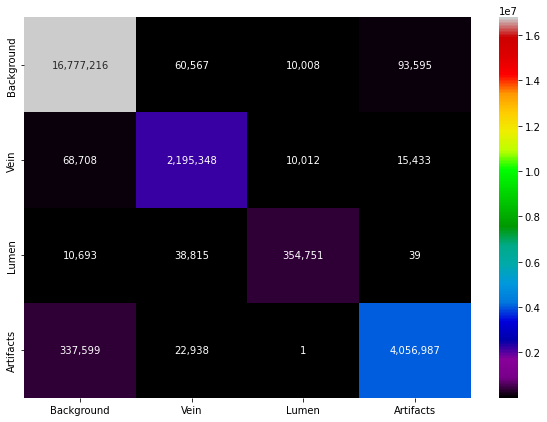

In [15]:
df_cm = pd.DataFrame(values, index = ['Background', 'Vein', 'Lumen', 'Artifacts'],
                  columns = ['Background', 'Vein', 'Lumen', 'Artifacts'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt=',d', cmap='nipy_spectral') 

In [80]:
values

array([[196946,   1407,     31,   1233],
       [  2081,  43201,     25,    296],
       [   320,    984,  11752,      0],
       [  4365,     48,      0,  33247]])

In [84]:
df_cm

,1,2,3,4
1,16777216,60567,10008,93595
2,68708,2195348,10012,15433
3,10693,38815,354751,39
4,337599,22938,1,4056987
